# qPCR Math in Python

## - Calculate the delta values between WT and KO and average 

## - Calculate the delta value of the averages and fold change

## - Calculate standard errors and variance

## - Graph the fold changes

## Import File

In [0]:
#import pandas and numpy
import pandas as pd
import numpy as np


In [2]:
#setup Google colab and import qPCR file
from google.colab import files
uploaded = files.upload()


Saving qpcr.xls to qpcr.xls


In [0]:
#create data frame from qPCR data
import io
qpcr = pd.read_excel(io.BytesIO(uploaded['qpcr.xls']), header=7)


## Clean the Data

In [4]:
#slice data frame
qpcr = qpcr.iloc[:, 0:-5]
qpcr.iloc[:,6] = pd.to_numeric(qpcr.iloc[:,6], errors='coerce')
qpcr.head()

,Well,Sample Name,Target Name,Task,Reporter,Quencher,Cт,Cт Mean,Cт SD,Quantity,...,Automatic Baseline,Baseline Start,Baseline End,Tm1,Tm2,Tm3,Comments,HIGHSD,EXPFAIL,MTP
0,A1,WTplus,T11a,UNKNOWN,SYBR,None,13.646971,13.419525,0.246278,NaN,...,True,1,2,83.609039,NaN,NaN,NaN,N,N,N
1,A2,WTplus,T11a,UNKNOWN,SYBR,None,13.157971,13.419525,0.246278,NaN,...,True,1,2,83.799431,NaN,NaN,NaN,N,N,N
2,A3,WTplus,T11a,UNKNOWN,SYBR,None,13.453634,13.419525,0.246278,NaN,...,True,1,2,83.799431,NaN,NaN,NaN,N,N,N
3,A4,WTplus,S15,UNKNOWN,SYBR,None,19.986971,19.786646,0.495761,NaN,...,True,3,12,90.653671,NaN,NaN,NaN,N,N,N
4,A5,WTplus,S15,UNKNOWN,SYBR,None,20.094048,19.786646,0.495761,NaN,...,True,3,12,90.653671,NaN,NaN,NaN,N,N,N


## Create First Dataframe of delta CT values

In [17]:
#prompt user for sample names
plates = []
for i in range(8):
    gene = input('Well letter and gene type: ')
    plates.append(gene)

Well letter and gene type: A WT
Well letter and gene type: A KO
Well letter and gene type: C WT 
Well letter and gene type: C KO
Well letter and gene type: E WT 
Well letter and gene type: E KO
Well letter and gene type: G WT 
Well letter and gene type: G KO


In [0]:
'''This cell calculates delta CT values for all samples'''

#create empty list for delta CT value calculations
deltaCT = []

#loop through WT and KO samples of each gene
#first checking for invalid values before running calculations
i = 0
a = 0 
b = 3
c = 6
d = 9
e = 12

while i < 4:
    
    #run WT calculations
    x = np.array(qpcr.iloc[a:b, 6])
    y = np.array(qpcr.iloc[b:c, 6])
    
    if np.isnan(x).any() or np.isnan(y).any():
        print('{plates}: A value is "Undetermined".'.format(plates=plates[i]))
    else:
        z = x - y 
    
    #run KO calculations
    x2 = np.array(qpcr.iloc[c:d, 6])
    y2 = np.array(qpcr.iloc[d:e, 6])
    
    
    if np.isnan(x2).any() or np.isnan(y2).any():
        print('{plates}: A value is "Undetermined".'.format(plates=plates[i]))
    else:
        z2 = x2 - y2
      
    #append calculated values to empty list
    deltaCT.append(z)
    deltaCT.append(z2)
     
    #skip negative control samples and go to next gene set
    a += 24
    b += 24
    c += 24
    d += 24
    e += 24
    i += 1
    
#concatenate array list
deltaCT = np.vstack(deltaCT)

#create data frame of calculated delta CT values
qPCR_df = pd.DataFrame(deltaCT, columns=['dCT1', 'dCT2', 'dCT3'], index=plates)

In [0]:
#calculate average delta CT values for each triplicate
deltaCT_avg = []
for array in deltaCT:
  average = np.mean(array)
  deltaCT_avg.append(average)

#add average values to data frame
qPCR_df['avg dCT'] = deltaCT_avg


## Calculate Second Dataframe of delta delta CT values

In [0]:
#calculate delta delta CT values
i=0
a=0
b=1

delta_deltaCT = []

while i < 4:
  mean = deltaCT_avg[b] - deltaCT_avg[a]
  delta_deltaCT.append(mean)
  i += 1
  a += 2
  b += 2
 

In [22]:
#set gene name for WT and KO samples being compared
genes = []
for i in range(4):
  numbers = ['1st', '2nd', '3rd', '4th']
  gene_names = input('What is the {numbers} gene being compared? '.format(numbers=numbers[i]))
  genes.append(gene_names)

What is the 1st gene being compared? 1ST
What is the 2nd gene being compared? 2ND
What is the 3rd gene being compared? 3RD
What is the 4th gene being compared? 4TH


In [0]:
#create data frame of gene samples being compared
gene_comparison_df = pd.DataFrame(delta_deltaCT, index=genes, columns = ['ddCT'])

In [0]:
#calculate fold change from delta delta CT values
fold_change = []
for value in delta_deltaCT:
  change = 2 ** (value * -1)
  fold_change.append(change)

#add fold change to data frame
gene_comparison_df['fold change'] = fold_change

## Create Third Dataframe of Standard Errors 

In [0]:
"""This cell calculates standard error for WT and KO variants of each gene"""

#import libraries
from math import sqrt

#calculate deviation of delta CT value of each sample from the averaged value
i=0
deltaCT_dev = []
for array in deltaCT:
  deviation = deltaCT[i] - deltaCT_avg[i] 
  deltaCT_dev.append(deviation)
  i += 1

deltaCT_dev = np.vstack(deltaCT_dev)

#create data frame for calculated error of data
error_df = pd.DataFrame(deltaCT_dev, index=plates, columns=['err dCT1', 'err dCT2', 'err dCT3'] )

#calculate fold change variance based on delta CT variation
fold_change_var = []
for array in deltaCT_dev:
  variance = 2 ** array
  fold_change_var.append(variance)

fold_change_var = np.vstack(fold_change_var)

#add fold change variances to data frame
fcv_df = pd.DataFrame(fold_change_var, index=plates, columns=['fc var 1', 'fc var 2', 'fc var 3'])
error_df = pd.concat([error_df, fcv_df], axis=1)

#calculate standard deviation of fold change
fc_std = []

for array in fold_change_var:
  sdev = np.std(array)
  fc_std.append(sdev)

#add standard deviation to data frame
error_df['fc SD'] = fc_std
  
#calculate standard error of fold change
fc_sem = []
for value in fc_std:
  error = value / sqrt(6)
  fc_sem.append(error)
  
#add standard error to data frame
error_df['fc SEM'] = fc_sem
  

## Graph the Fold Change

In [0]:
#create normalized WT data
WT_data = []
for i in range(4):
  WT_data.append(1)

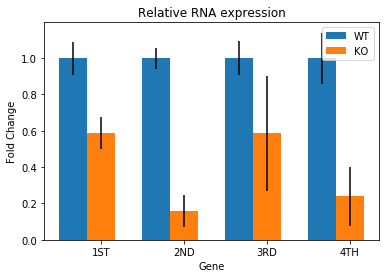

In [28]:
#import matplotlib
import matplotlib.pyplot as plt

#set bar positions and width
barPosition = [0, 0.75, 1.5, 2.25]
barWidth = 0.25

#define error
WT_error = fc_sem[::2]
KO_error = fc_sem[1::2]

#create WT bars
plt.bar(x=barPosition, height=WT_data, width=barWidth, tick_label=genes, yerr=WT_error)

#create KO bars
plt.bar(x=[p + barWidth for p in barPosition], height=fold_change, width=barWidth, tick_label=genes, yerr=KO_error)


#set axis titles and graph title
plt.xlabel('Gene')
plt.ylabel('Fold Change')
plt.title('Relative RNA expression')
plt.legend(['WT', 'KO'])

#show graph
plt.show()

## Print the Dataframes

In [29]:
#show data tables
print(qPCR_df)
print(gene_comparison_df)
print(error_df)

           dCT1      dCT2      dCT3   avg dCT
A WT  -6.340000 -6.936076 -6.998049 -6.758042
A KO  -6.359312 -5.619376 -6.007844 -5.995511
C WT  -6.517894 -6.483096 -6.088112 -6.363034
C KO  -3.838646 -3.966069 -3.287014 -3.697243
E WT  -2.668890 -3.357101 -3.243961 -3.089984
E KO  -3.027693 -2.808130 -1.117119 -2.317647
G WT  -8.989766 -7.950086 -8.750294 -8.563382
G KO  -6.958577 -6.755314 -5.808542 -6.507478
         ddCT  fold change
1ST  0.762531     0.589461
2ND  2.665791     0.157586
3RD  0.772337     0.585468
4TH  2.055904     0.240498
       err dCT1  err dCT2  err dCT3  fc var 1  fc var 2  fc var 3     fc SD  \
A WT   0.418042 -0.178034 -0.240007  1.336113  0.883906  0.846741  0.222450   
A KO  -0.363801  0.376135 -0.012333  0.777114  1.297860  0.991488  0.213696   
C WT  -0.154860 -0.120062  0.274922  0.898220  0.920148  1.209929  0.142055   
C KO  -0.141403 -0.268826  0.410229  0.906637  0.829995  1.328897  0.219363   
E WT   0.421094 -0.267117 -0.153977  1.338943  0.830978 

## Save to Excel

In [0]:
#save calculations as excel files
with pd.ExcelWriter('{file} calculations.xlsx'.format(file=file)) as writer:
    qPCR_df.to_excel(writer, sheet_name='dCT')
    gene_comparison_df.to_excel(writer, sheet_name='ddCT & fold change')
    error_df.to_excel(writer, sheet_name='calculated error')